This is part of the regression analysis we did. I left with outputs and everything for inspiration.

# Reading data

In [1]:
import pandas as pd

pollution_data = pd.read_csv('amagerdata.csv')

pollution_data.head()

,ROAD_FID,local_time,Data_NO2,Mixed_NO2,UFP,Mixed_UFP,Data_BC,Mixed_BC
0,36,2019-06-25 10:00:00,NaN,16.0,13300.0,9850.0,NaN,0.9
1,36,2020-02-11 08:00:00,13.0,16.0,NaN,9850.0,NaN,0.9
2,36,2020-02-18 08:00:00,11.0,16.0,NaN,9850.0,NaN,0.9
3,36,2019-11-09 08:00:00,13.0,16.0,8120.0,9850.0,0.7,0.9
4,36,2019-11-01 07:00:00,15.0,16.0,33400.0,9850.0,1.2,0.9


In [2]:
windspeed_data = pd.read_csv('wind_speed_past1h.csv')

windspeed_data.head()

,id,type,geometry.coordinates,geometry.type,properties.created,properties.observed,properties.parameterId,properties.stationId,properties.value
0,df1c67e7-214d-894a-39de-caac91ae7f44,Feature,"12.562,55.716",Point,2021-01-19T23:23:25.232092Z,2020-03-12T00:00:00Z,wind_speed_past1h,6184,3.1
1,76aa72c4-3627-816e-7b0e-403a0ec7e22b,Feature,"12.562,55.716",Point,2021-01-19T23:23:25.172549Z,2020-03-11T23:00:00Z,wind_speed_past1h,6184,2.9
2,8c7b3f27-1268-4828-3e6a-9ce0e8373854,Feature,"12.562,55.716",Point,2021-01-19T23:23:25.042567Z,2020-03-11T22:00:00Z,wind_speed_past1h,6184,2.9
3,61831e57-3ae9-a456-5928-206e81362f06,Feature,"12.562,55.716",Point,2021-01-19T23:23:24.861411Z,2020-03-11T21:00:00Z,wind_speed_past1h,6184,2.9
4,8b05ab97-88b4-ad8a-c95e-bec638039af6,Feature,"12.562,55.716",Point,2021-01-19T23:23:24.670886Z,2020-03-11T20:00:00Z,wind_speed_past1h,6184,3.0


# Initial plot
Here, we simply look at daily averages of UFP data across all measurements and compare them with the wind speed data in a line graph.

<AxesSubplot:label='232dc690-8e16-4999-87cf-d6d6e3724ed0', xlabel='local_time', ylabel='UFP'>

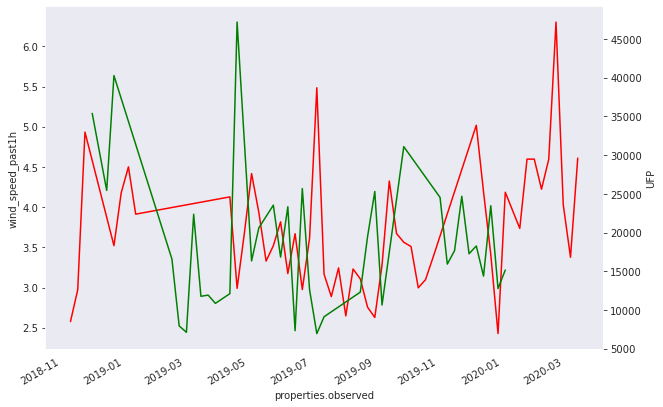

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

fig, ax1 = plt.subplots(figsize=(10,7))

windspeed_data['properties.observed'] = pd.to_datetime(windspeed_data['properties.observed'])
windspeed_data['properties.observed'] = windspeed_data['properties.observed'].dt.tz_convert('UTC').dt.tz_convert('Europe/Copenhagen')
windspeed_data.set_index('properties.observed').groupby(pd.Grouper(freq='W'))['properties.value'].mean().dropna().plot(
    ax=ax1,
    color='red',
    ylabel='wind_speed_past1h'
)

ax2 = ax1.twinx()

pollution_data['local_time'] = pd.to_datetime(pollution_data['local_time'])
pollution_data['local_time'] = pollution_data['local_time'].dt.tz_localize('UTC').dt.tz_convert('Europe/Copenhagen')
pollution_data.set_index('local_time').groupby(pd.Grouper(freq='W'))['UFP'].mean().dropna().plot(
    ax=ax2,
    color='green',
    ylabel='UFP'
)

# Regression analysis: Windspeed as a predictor for UFP
First, a scatter plot to see what the data looks like.

<AxesSubplot:xlabel='X', ylabel='Y'>

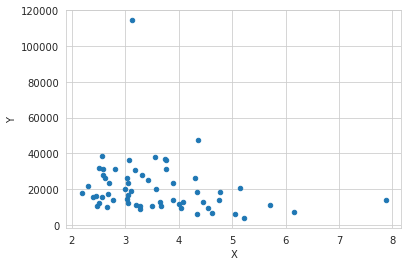

In [4]:
X = windspeed_data.set_index('properties.observed')['properties.value'].sort_index()
Y = pollution_data.set_index('local_time')['UFP'].sort_index()

X = X[(X.index > Y.index.min()) & (X.index < Y.index.max())]

X = X.groupby(X.index.date).mean()
Y = Y.groupby(Y.index.date).mean()

corr_df = pd.DataFrame({'X': X, 'Y': Y}).dropna()

sns.set_style('whitegrid')
corr_df.plot(x='X', y='Y', kind='scatter')

We find the linear correlation between wind speed and UFP

In [5]:
corr_df.corr(method='pearson')

,X,Y
X,1.000000,-0.221939
Y,-0.221939,1.000000


This shows a fairly strong negative correlation. Thus, more wind leads to less air pollution (UFP)

We then calculate the the p-value (how likely is it that our data could have occurred if there were no relationship between our variables of interest).

In [6]:
from scipy.stats import pearsonr

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

corr_df.corr(method=pearsonr_pval)

,X,Y
X,1.000000,0.088326
Y,0.088326,1.000000


p < 0.05, looks good.

In [7]:
import statsmodels.formula.api as sm

result = sm.ols(formula="Y ~ X", data=corr_df).fit()
print(result.params)

Intercept    32486.046726
X            -3274.156943
dtype: float64


In [8]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.005
Date:                Wed, 02 Jun 2021   Prob (F-statistic):             0.0883
Time:                        15:38:42   Log-Likelihood:                -662.98
No. Observations:                  60   AIC:                             1330.
Df Residuals:                      58   BIC:                             1334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.249e+04   7068.089      4.596      0.0

# Looking at wind direction

In [9]:
winddir_data = pd.read_csv('wind_dir_past1h.csv')
winddir_data['properties.observed'] = pd.to_datetime(winddir_data['properties.observed'])

winddir_data.head()

,id,type,geometry.coordinates,geometry.type,properties.created,properties.observed,properties.parameterId,properties.stationId,properties.value
0,bb2e0d8f-d61f-464a-caf7-3ce721ca6f02,Feature,"12.562,55.716",Point,2021-01-19T23:23:25.231878Z,2020-03-12 00:00:00+00:00,wind_dir_past1h,6184,195.0
1,6156f933-27d0-5801-1c91-b7e0f65079ab,Feature,"12.562,55.716",Point,2021-01-19T23:23:25.172349Z,2020-03-11 23:00:00+00:00,wind_dir_past1h,6184,185.0
2,0601ff12-91c0-4c0a-4354-0ac7b0e5a5f6,Feature,"12.562,55.716",Point,2021-01-19T23:23:25.042351Z,2020-03-11 22:00:00+00:00,wind_dir_past1h,6184,188.0
3,c8650f7f-0644-e474-4322-f69c12dad030,Feature,"12.562,55.716",Point,2021-01-19T23:23:24.861206Z,2020-03-11 21:00:00+00:00,wind_dir_past1h,6184,193.0
4,8c3013f1-a4db-04e5-44fc-e91e1e9eb26d,Feature,"12.562,55.716",Point,2021-01-19T23:23:24.670683Z,2020-03-11 20:00:00+00:00,wind_dir_past1h,6184,200.0


In [10]:
from collections import ChainMap

ds = [
    {0: 'calm'},
    {d:'N' for d in range(315, 361)},
    {d:'N' for d in range(1, 45)},
    {d:'E' for d in range(45, 135)},
    {d:'S' for d in range(135, 225)},
    {d:'W' for d in range(225, 315)},
]

deg_dct = dict(ChainMap(*ds))

windspeed_data['dir'] = winddir_data['properties.value']
windspeed_data['dir_cardinal'] = windspeed_data['dir'].apply(lambda deg: deg_dct[deg])

In [11]:
Y = pollution_data.set_index('local_time')['UFP'].sort_index()
Y = Y.groupby(Y.index.date).mean()

windspeed_data_nocalm = windspeed_data[~(windspeed_data['dir_cardinal'] == 'calm')]

for name, group in windspeed_data_nocalm.groupby('dir_cardinal'):
    X = group.set_index('properties.observed')['properties.value'].sort_index()
    X = X.groupby(X.index.date).mean()
    corr_df = pd.DataFrame({'X': X, 'Y': Y}).dropna()

    print(f"\033[1mDirection: {name}\033[0m")
    print('*Coef*')
    print(corr_df.corr(), '\n')
    print('*P value*')
    print(corr_df.corr(method=pearsonr_pval), '\n\n')

Direction: E
*Coef*
          X         Y
X  1.000000 -0.050314
Y -0.050314  1.000000 

*P value*
          X         Y
X  1.000000  0.795484
Y  0.795484  1.000000 


Direction: N
*Coef*
          X         Y
X  1.000000  0.871119
Y  0.871119  1.000000 

*P value*
         X        Y
X  1.00000  0.00103
Y  0.00103  1.00000 


Direction: S
*Coef*
          X         Y
X  1.000000 -0.195967
Y -0.195967  1.000000 

*P value*
          X         Y
X  1.000000  0.186786
Y  0.186786  1.000000 


Direction: W
*Coef*
          X         Y
X  1.000000 -0.279384
Y -0.279384  1.000000 

*P value*
          X         Y
X  1.000000  0.089371
Y  0.089371  1.000000 




Only West has a p-value under 0.05 (0.039302), and thus is the only direction for which we can say with a high degree of certainty that our correlation (-0.44) is actually true.

In [44]:
cardinal_series = windspeed_data.set_index('properties.observed')['dir_cardinal']
cardinal_series = cardinal_series.sort_index()
cardinal_series.to_csv('cardinal.csv')

In [36]:
ufp_series = pollution_data.set_index('local_time')['UFP']
ufp_series = ufp_series.sort_index()
ufp_series.index[50]

Timestamp('2018-11-28 10:00:00+0100', tz='Europe/Copenhagen')

In [43]:
cardinal_ufp_df = pd.merge_asof(cardinal_series, ufp_series, left_index=True, right_index=True, direction='nearest')
cardinal_ufp_df

,dir_cardinal,UFP
properties.observed,,
2018-11-05 01:00:00+01:00,E,37700.0
2018-11-05 02:00:00+01:00,E,37700.0
2018-11-05 03:00:00+01:00,E,37700.0
2018-11-05 04:00:00+01:00,E,37700.0
2018-11-05 05:00:00+01:00,E,37700.0
...,...,...
2020-03-11 21:00:00+01:00,S,NaN
2020-03-11 22:00:00+01:00,S,NaN
2020-03-11 23:00:00+01:00,S,NaN


In [31]:
cardinal_dct = cardinal_series.to_dict()

In [41]:
def find_closest_observed_wind_observation(ufp_date):
    wind_date = min(cardinal_dct.keys(), key=lambda x: abs(x - ufp_date))
    print(ufp_date)
    print(wind_date)
    if abs(ufp_date-wind_date) 
    return cardinal_dct[wind_date]


find_closest_observed_wind_observation(ufp_series.index[550])

2018-12-17 13:00:00+01:00
2018-12-20 09:00:00+01:00


'E'

In [58]:
(ufp_series.index[100] - ufp_series.index[0])

Timedelta('0 days 00:00:00')

In [62]:
ufp_series

local_time
2018-11-28 10:00:00+01:00    37700.0
2018-11-28 10:00:00+01:00    30800.0
2018-11-28 10:00:00+01:00    25500.0
2018-11-28 10:00:00+01:00    60000.0
2018-11-28 10:00:00+01:00    11300.0
                              ...   
2020-02-27 21:00:00+01:00        NaN
2020-02-27 21:00:00+01:00        NaN
2020-03-10 09:00:00+01:00        NaN
2020-03-10 20:00:00+01:00        NaN
2020-03-11 18:17:31+01:00        NaN
Name: UFP, Length: 21932, dtype: float64

In [61]:
ufp_series

local_time
2018-11-28 10:00:00+01:00    37700.0
2018-11-28 10:00:00+01:00    30800.0
2018-11-28 10:00:00+01:00    25500.0
2018-11-28 10:00:00+01:00    60000.0
2018-11-28 10:00:00+01:00    11300.0
                              ...   
2020-02-27 21:00:00+01:00        NaN
2020-02-27 21:00:00+01:00        NaN
2020-03-10 09:00:00+01:00        NaN
2020-03-10 20:00:00+01:00        NaN
2020-03-11 18:17:31+01:00        NaN
Name: UFP, Length: 21932, dtype: float64

In [15]:
import numpy as np

cardinal_ufp_df = cardinal_ufp_df.groupby(pd.Grouper(freq='D')).agg({'dir_cardinal': 'max', 'UFP': np.mean})

In [16]:
cardinal_ufp_df

,dir_cardinal,UFP
properties.observed,,
2018-11-05 00:00:00+01:00,E,37700.0
2018-11-06 00:00:00+01:00,S,37700.0
2018-11-07 00:00:00+01:00,S,37700.0
2018-11-08 00:00:00+01:00,W,37700.0
2018-11-09 00:00:00+01:00,W,37700.0
...,...,...
2020-03-08 00:00:00+01:00,S,NaN
2020-03-09 00:00:00+01:00,W,NaN
2020-03-10 00:00:00+01:00,NaN,NaN


In [17]:
import json

with open('CPH_MixedModels_25May2021b.geojson', 'r') as f:
    cph = json.load(f)
    
cph.keys()

dict_keys(['type', 'features'])

In [18]:
fid_coords = {i['properties']['ROAD_FID']: i['geometry']['coordinates'] for i in cph['features']}

In [19]:
pollution_data['ROAD_FID_coords'] = pollution_data['ROAD_FID'].map(fid_coords)

In [20]:
pollution_data = pollution_data.sort_values(by='local_time')
pollution_data = pd.merge_asof(pollution_data, cardinal_series, left_on='local_time', right_index=True, direction='nearest')

In [21]:
dfs = list()
for name, group in pollution_data.groupby('dir_cardinal'):
    subdf = group.groupby('ROAD_FID').agg({'ROAD_FID_coords': 'first', 'UFP': np.mean})
    subdf['ROAD_FID_coords'] = subdf['ROAD_FID_coords'].apply(lambda x: x[0])
    subdf['lng'], subdf['lat'] = zip(*subdf['ROAD_FID_coords'])
    subdf.name = name
    subdf.to_csv(f'cardinal_splits/{name}.csv')
    dfs.append(subdf)

In [22]:
cardinal_series.value_counts()

W       2668
S       2264
E       1621
N        482
calm       2
Name: dir_cardinal, dtype: int64

In [23]:
pollution_data['ROAD_FID'].value_counts()

30396    153
29589    152
27402    152
2103     152
22431    152
        ... 
2512       1
8053       1
9922       1
18936      1
17946      1
Name: ROAD_FID, Length: 1563, dtype: int64

In [24]:
pollution_data

,ROAD_FID,local_time,Data_NO2,Mixed_NO2,UFP,Mixed_UFP,Data_BC,Mixed_BC,ROAD_FID_coords,dir_cardinal
10862,23123,2018-11-28 10:00:00+01:00,NaN,11.0,37700.0,9360.0,0.4,1.0,"[[12.566310109778321, 55.64647481495054], [12....",E
18424,30014,2018-11-28 10:00:00+01:00,NaN,13.0,30800.0,10700.0,0.5,0.9,"[[12.567683832546429, 55.65264697453324], [12....",E
130,181,2018-11-28 10:00:00+01:00,NaN,13.0,25500.0,12400.0,0.6,1.1,"[[12.57457732437652, 55.64208017844679], [12.5...",E
4147,9742,2018-11-28 10:00:00+01:00,NaN,26.0,60000.0,26900.0,0.6,1.7,"[[12.57534698492308, 55.64099837865791], [12.5...",E
17425,29272,2018-11-28 10:00:00+01:00,NaN,14.0,11300.0,19900.0,0.7,0.9,"[[12.571412153741747, 55.62961845646826], [12....",E
...,...,...,...,...,...,...,...,...,...,...
1990,4041,2020-02-27 21:00:00+01:00,12.0,30.0,NaN,17100.0,NaN,1.8,"[[12.587405381341311, 55.66702524530388], [12....",W
13485,26330,2020-02-27 21:00:00+01:00,12.0,28.0,NaN,17600.0,NaN,1.7,"[[12.58755973917106, 55.66733357294719], [12.5...",W
1323,2103,2020-03-10 09:00:00+01:00,7.0,38.0,NaN,23400.0,NaN,2.3,"[[12.57983701400161, 55.6697374667821], [12.57...",S
8045,18584,2020-03-10 20:00:00+01:00,14.0,21.0,NaN,12300.0,NaN,1.2,"[[12.585500814071768, 55.66592982422509], [12....",W
